In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math as math
import scipy.integrate as integrate
from scipy.interpolate import griddata
from scipy import special
from matplotlib import cm
import emcee
from psrqpy import QueryATNF
import scipy

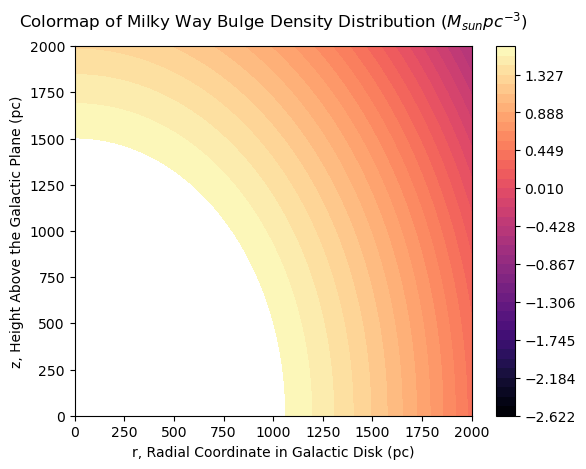

In [2]:
x = np.linspace(0, 3000, 2001) 
y = np.linspace(0, 3000, 2001)
z = np.linspace(0, 3000, 2001)

r = np.sqrt(x**2 + y**2)

#MSP density distribution:
rho_0_MW = 45.27 #M_sun pc^-3
a_0 = 100 #pc
a_m = 1900 #pc


#density distribution for NSC, r^2 = x^2 + y^2 + z^2:
def rho_MWB(r, z, rho_0_MW, a_0, a_m): 
    a = np.sqrt(r**2 + z**2)
    return rho_0_MW*np.exp(-(a**2)/(a_m**2))*(1 + (a/a_m))**(-1.8)

#python has a stroke if you don't vectorize things (becuase functions can't take arrays
#as inputs normally)
vrho_MWB = np.vectorize(rho_MWB)
rho_MWB = vrho_MWB(r, z, rho_0_MW, a_0, a_m)

#plotting code:
r_plot = r
z_plot = z.reshape(-1, 1)

rho_MWB_plot = rho_0_MW*np.exp(-(r_plot**2 + z_plot**2)/(a_m**2))*(1 + (np.sqrt(r_plot**2 + z_plot**2)/a_m))**(1.8)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cont = ax.contourf(np.log10(rho_MWB_plot), cmap=cm.magma, levels = np.linspace(np.log10(rho_MWB).min(), np.log10(rho_MWB).max(), 40).tolist())  
#surf = ax.plot_surface(Rgrid, zgrid, rho_disk_plot)
plt.colorbar(cont)

#print(rho_disk_plot)

plt.title("Colormap of Milky Way Bulge Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("r, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

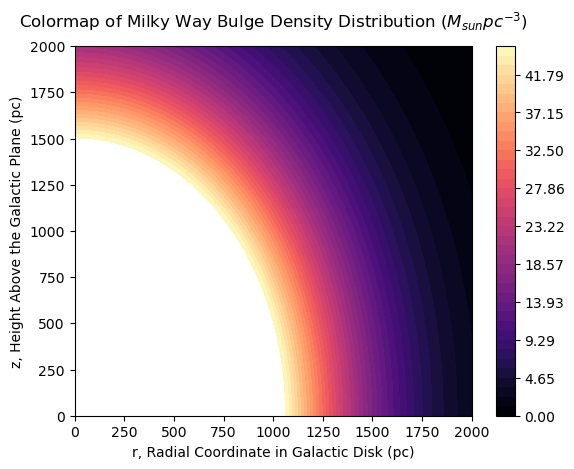

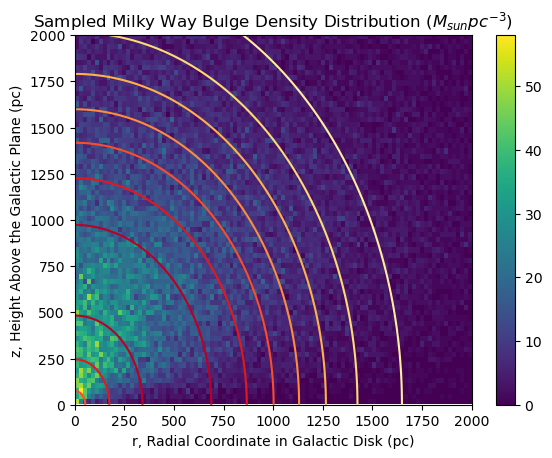

In [3]:
#try MCMC sampling on the conditional probabilities of rho bulge
#plot the test function
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
cont = ax.contourf(rho_MWB_plot, cmap=cm.magma, levels = np.linspace(rho_MWB.min(), rho_MWB.max(), 40).tolist())  
plt.colorbar(cont)

plt.title("Colormap of Milky Way Bulge Density Distribution ($M_{sun} pc^{-3}$)" , y = 1.03)
plt.xlabel("r, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")

plt.show()

def rho_MWB_sample(a, rho_0_MW, a_0, a_m):
    if (0 < a < math.sqrt(2)*2000):
        return np.log(rho_0_MW*np.exp(-(a**2)/(a_m**2))*(1 + (a/a_m))**(-1.8))
    else:
        return -np.inf

#try MCMC sampling using emcee
ndim = 1
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

rho_MWB_sampler = emcee.EnsembleSampler(nwalkers, ndim, rho_MWB_sample, args=[rho_0_MW, a_0, a_m])
rho_MWB_state = rho_MWB_sampler.run_mcmc(p0, 100)
rho_MWB_sampler.reset()

rho_MWB_sampler.run_mcmc(rho_MWB_state, 5000)

samples_a = rho_MWB_sampler.get_chain(flat=True)
a_plot = samples_a[:, 0]

r_plot = np.random.randint(2001, size = a_plot.size)
z_plot = np.sqrt(a_plot**2 - r_plot**2)[~np.isnan(np.sqrt(a_plot**2 - r_plot**2))]
r_plot_2 = r_plot[~np.isnan(np.sqrt(a_plot**2 - r_plot**2))]

plt.hist2d(r_plot_2, z_plot, bins = 100) #x = r, y = z
plt.colorbar()

#plot counters of rho_disk to check accuracy of sampling
plt.contour(rho_MWB_plot, cmap = "YlOrRd")
plt.title("Sampled Milky Way Bulge Density Distribution ($M_{sun} pc^{-3}$)")
plt.xlabel("r, Radial Coordinate in Galactic Disk (pc)")
plt.ylabel("z, Height Above the Galactic Plane (pc)")
plt.xlim(0, 2000)
plt.ylim(0, 2000)
#plt.gca().set_yticks([])
plt.show()

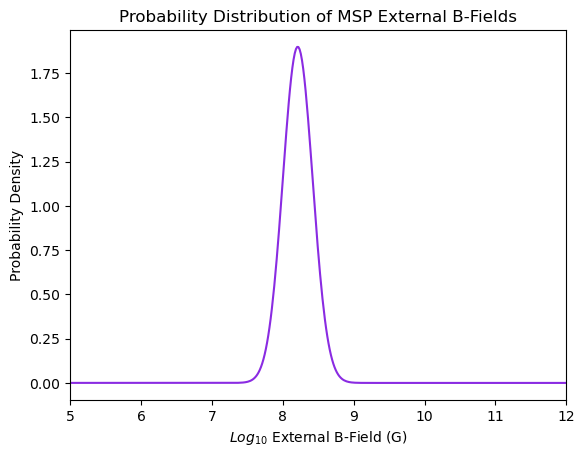

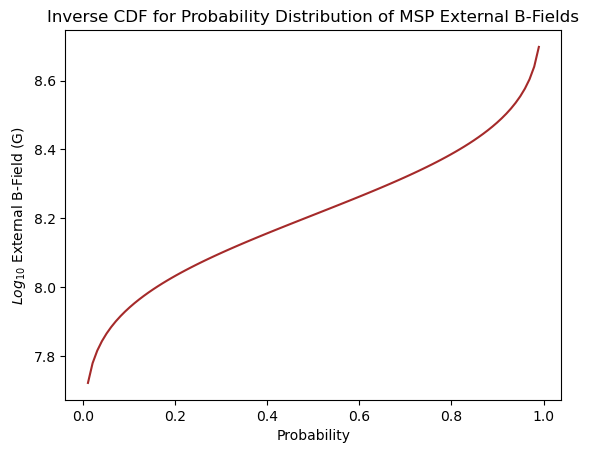

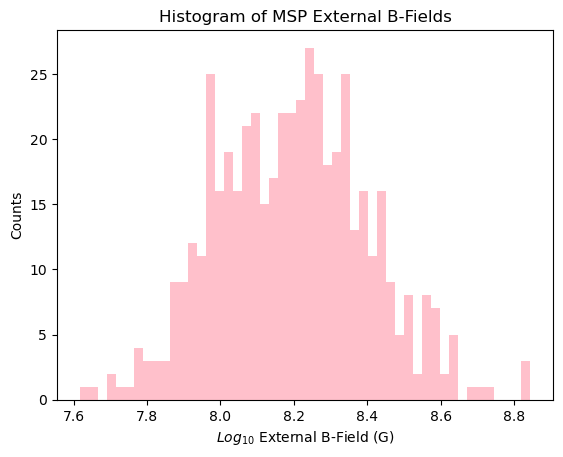

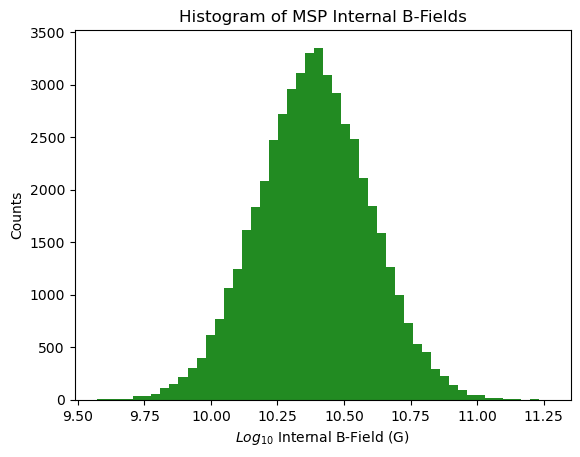

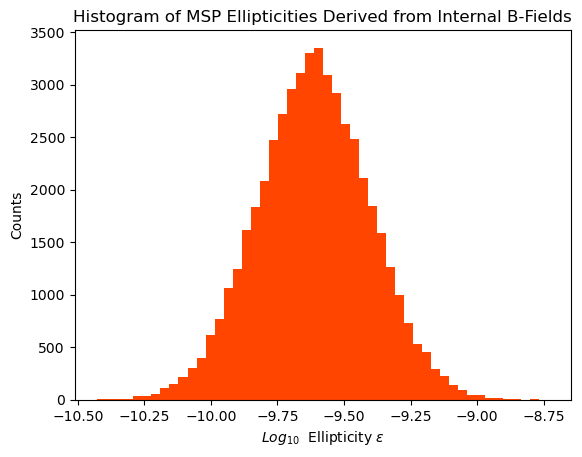

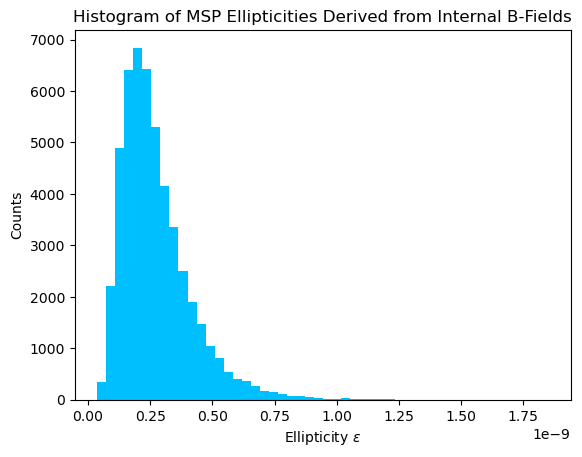

In [4]:
#plot the moment of inertia (ellipticity?) distribution for MSPs

#to find the ellipticity distribution, Miller et al. uses two methods. We'll adopt the 1st:
#assume the deformations are caused by the internal magnetic field

#averages of log10(B_med) and sigma_B from Ploeg et al., which is a fairly different range than
#what Miller et al. has for their B-fields
log_10_B_med = 8.21 #B_med in G 
sigma_B = 0.21 

#we have to inverse transform sample this to get a distribution of B fields
def p_B(log_10_B, sigma_B, log_10_B_med): 
    return (1/((np.sqrt(2*np.pi)*sigma_B)))*np.exp(-((log_10_B - log_10_B_med)**2)/(2*(sigma_B**2)))

plt.plot(np.linspace(0, 17, 1000), p_B(np.linspace(0, 17, 1000), sigma_B, log_10_B_med), color = "blueviolet")
plt.title("Probability Distribution of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Probability Density")
plt.xlim(5, 12)
plt.show()

def inv_cdf_p_B(log_10_B, sigma_B, log_10_B_med):
    return log_10_B_med - math.sqrt(2)*sigma_B*special.erfinv(-2*log_10_B + 1)

plt.plot(np.linspace(0, 1, 100), inv_cdf_p_B(np.linspace(0, 1, 100), sigma_B, log_10_B_med), color = "brown")
plt.title("Inverse CDF for Probability Distribution of MSP External B-Fields")
plt.ylabel("$Log_{10}$ External B-Field (G)")
plt.xlabel("Probability")
plt.show()

#sample the distribution
sample = np.random.rand(500)
plt.hist(inv_cdf_p_B(sample, sigma_B, log_10_B_med), 50, color = "pink")
plt.title("Histogram of MSP External B-Fields")
plt.xlabel("$Log_{10}$ External B-Field (G)")
plt.ylabel("Counts")
plt.show()

#so B_ext is:
sample = np.random.rand(50000)
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext

#according to Miller et al. B_int = 150*B_ext (conservatively, could be up to 10^4 times greater):
#try 150, 1000, 10,000 times to see if conincides with min. ellipticity of 10^-9 from Woan, etc.?
B_int = 150*B_ext

plt.hist(np.log10(B_int), 50, color = "forestgreen")
plt.title("Histogram of MSP Internal B-Fields")
plt.xlabel("$Log_{10}$ Internal B-Field (G)")
plt.ylabel("Counts")
plt.show()

#ellipticity is then given by 10^-8*(b_int*(10^-12)), or in log scale:
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

#find the log10(ellipticity):
epsilon_log = np.log10(epsilon_B)

#plot log10(ellipticity)
plt.hist(epsilon_log, 50, color = "orangered")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("$Log_{10}$  Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

#plot regular ellipticity
plt.hist(epsilon_B, 50, color = "deepskyblue")
plt.title("Histogram of MSP Ellipticities Derived from Internal B-Fields")
plt.xlabel("Ellipticity $\epsilon$")
plt.ylabel("Counts")
plt.show()

In [8]:
#we start out with the origin at the GC
a_GC = np.random.choice(samples_a[:, 0], size = 4000000) #used to be 40,000
r_sun = 8500 #pc (dist. to Sun so we can translate to galactic coords.)

#define a spherical dist. of theta and phi for the population in the GC frame
phi_range = np.linspace(0, 2*math.pi, 4000000)
theta_range = np.linspace(0, math.pi, 4000000)

phi_GC = np.random.choice(phi_range, size = 4000000)
theta_GC = np.random.choice(theta_range, size = 4000000)

#convert coordinates system to cartesian and into galactic coords.
x = (a_GC*np.sin(theta_GC)*np.cos(phi_GC)) - r_sun
y = a_GC*np.sin(theta_GC)*np.sin(phi_GC)
z = a_GC*np.cos(theta_GC)

#find dist in galactic coordinates
dist = np.sqrt(x**2 + y**2 + z**2)
R = np.sqrt(x**2 + y**2)

MWB_size = z.size
print(MWB_size)
print(np.average(dist))

4000000
8539.434575449037


In [11]:
#for the original population size of 40,000
#we start out with the origin at the GC
a_GC_small = np.random.choice(samples_a[:, 0], size = 40000) #used to be 40,000
r_sun = 8500 #pc (dist. to Sun so we can translate to galactic coords.)

#define a spherical dist. of theta and phi for the population in the GC frame
phi_range_small = np.linspace(0, 2*math.pi, 40000)
theta_range_small = np.linspace(0, math.pi, 40000)

phi_GC_small = np.random.choice(phi_range_small, size = 40000)
theta_GC_small = np.random.choice(theta_range_small, size = 40000)

#convert coordinates system to cartesian and into galactic coords.
x_small = (a_GC_small*np.sin(theta_GC_small)*np.cos(phi_GC_small)) - r_sun
y_small = a_GC_small*np.sin(theta_GC_small)*np.sin(phi_GC_small)
z_small = a_GC_small*np.cos(theta_GC_small)

#find dist in galactic coordinates
dist_small = np.sqrt(x_small**2 + y_small**2 + z_small**2)
R_small = np.sqrt(x_small**2 + y_small**2)

MWB_small_size = z_small.size
print(MWB_small_size)
print(np.average(dist_small))

40000
8540.33576621228


In [12]:
#to find the collective signal, need to restrict population to an 
#angular size of 10 deg. (roughly that of the GC)
angle = 10 #deg.
ang_rad = r_sun*math.tan(angle*(math.pi/180))
exclu_dist = math.sqrt(r_sun**2 + ang_rad**2)

#10 deg. => radial distance of less than or equal to 8631
dist_ang = dist[dist <= exclu_dist] 

#find size of this new population for finding collective signal later
dist_ang_size = dist_ang.size
print(dist_ang_size)

2790236


In [14]:
#find the corresponding theta and phi value in galactic coords.
init_theta = (np.arccos(z/dist)) - (math.pi/2) #dec.
init_phi = np.arctan(y/x) #ra.

#find the same for the small pop. size
init_theta_small = (np.arccos(z_small/dist_small)) - (math.pi/2) #dec.
init_phi_small = np.arctan(y_small/x_small) #ra.

#convert from ra and dec to galactic?
from astropy import units as u
from astropy.coordinates import SkyCoord

gal = SkyCoord(init_phi[:], init_theta[:], frame='galactic', unit=u.deg)

#find eliipticity
sample = np.random.rand(4000000) #40000
B_log_ext = inv_cdf_p_B(sample, sigma_B, log_10_B_med)
B_ext = 10**B_log_ext
B_int = 150*B_ext
rescaled_B_int = B_int/(10**12)
epsilon_B = (10**-8)*rescaled_B_int

#find ellipticity for smaller pop. size
sample_small = np.random.rand(40000) #40000
B_log_ext_small = inv_cdf_p_B(sample_small, sigma_B, log_10_B_med)
B_ext_small = 10**B_log_ext_small
B_int_small = 150*B_ext_small
rescaled_B_int_small = B_int_small/(10**12)
epsilon_B_small = (10**-8)*rescaled_B_int_small

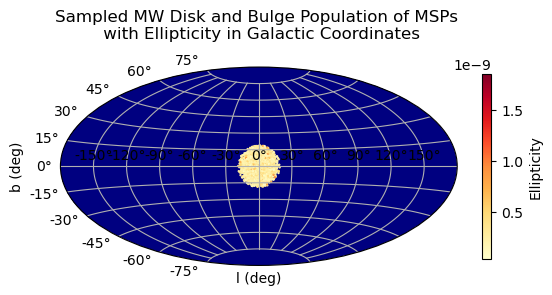

In [16]:
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('YlOrRd')
ep_rand_small = np.random.choice(epsilon_B, size = MWB_small_size) #size = 40000
ep_rand = np.random.choice(epsilon_B, size = MWB_size)

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(init_phi_small, init_theta_small, c = ep_rand_small, s = 0.5, cmap = 'YlOrRd')

cb = plt.colorbar(sc, label = "Ellipticity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Ellipticity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

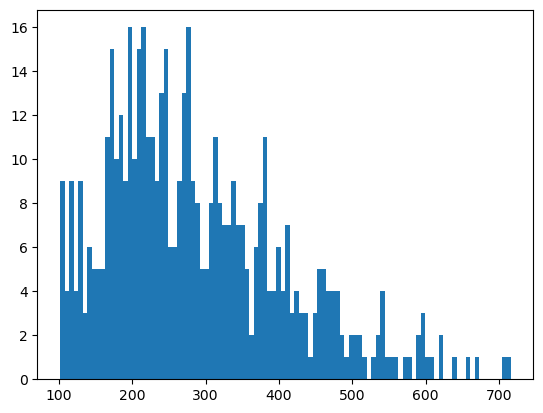

288.2443907316967
121.36792366842593


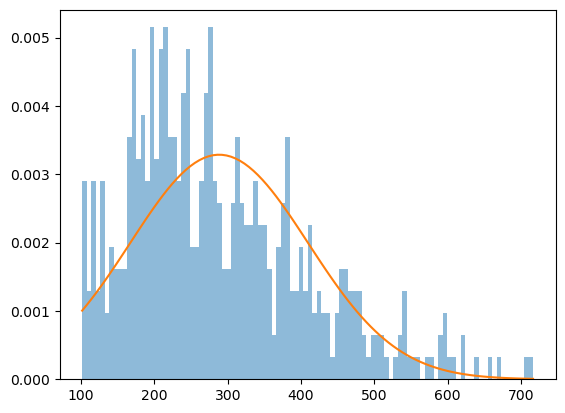

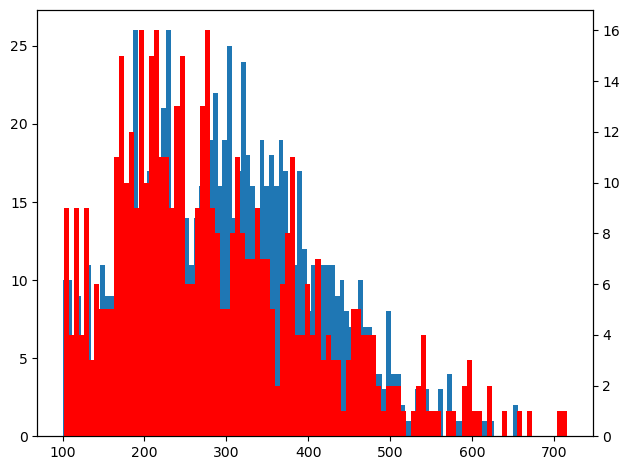

In [18]:
#to find the GW signal, we need to find the rotational frequency distribution
#need to query the ATNF database
from psrqpy import QueryATNF
import scipy
freq_query = QueryATNF(params=['F0'], condition = 'P0 < 0.01')

freq_df = freq_query.dataframe
freq_array = freq_df.to_numpy().flatten()[~np.isnan(freq_df.to_numpy().flatten())]
#print(freq_array.size) #is 855
#print(freq_array)

#frequency comes in 2 populations: high and low
high_freq_array = freq_array[freq_array > 100]

plt.hist(high_freq_array, 100)
plt.show()

#we only have 855 MSPs from the ATNF catalgoue with F0 data --> need to create a distribution
#look at just the high freq. array to begin b/c the low one is strange
_, bins, _ = plt.hist(high_freq_array, 100, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(high_freq_array)

#find mu and sigma
print(mu)
print(sigma)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

#create distribution
high_freq_dist = np.random.normal(mu, sigma, 1000)
fig, ax1 = plt.subplots()

ax1.hist(high_freq_dist[high_freq_dist > 100], bins = 100)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#ax2.plot(best_fit_line, color = "red")
ax2.hist(high_freq_array, 100, color = "red")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#now generate a sample of 40000
norm_freq_sample = np.random.normal(mu, sigma, 4000000)
freq_sample = np.random.choice(norm_freq_sample[norm_freq_sample >= 100], MWB_size) #40000 as last number
freq_sample_small = np.random.choice(norm_freq_sample[norm_freq_sample >= 100], MWB_small_size)

40000


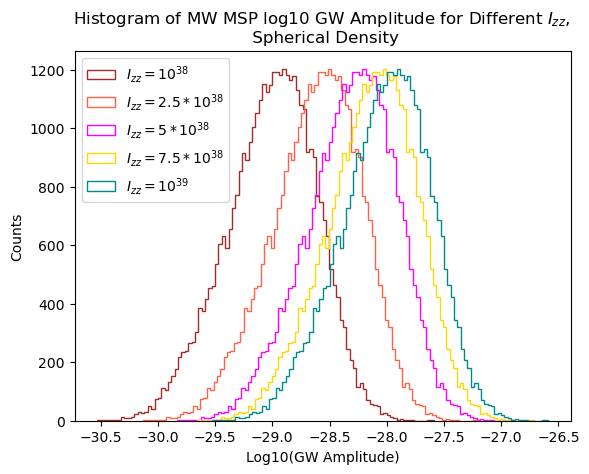

In [19]:
#the equation for the GW amplitude from Miller et al.:
#moment of inertia ranges from 10^38 to 10^39 kg m^2, choose 5 values
I_zz_1 = 10**38
I_zz_2 = 2.5*(10**38)
I_zz_3 = 5*(10**38)
I_zz_4 = 7.5*(10**38)
I_zz_5 = 10**39

init_A_GW_1 = (16*(math.pi**2)*(6.67e-11)*(I_zz_1)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_2 = (16*(math.pi**2)*(6.67e-11)*(I_zz_2)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_3 = (16*(math.pi**2)*(6.67e-11)*(I_zz_3)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_4 = (16*(math.pi**2)*(6.67e-11)*(I_zz_4)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
init_A_GW_5 = (16*(math.pi**2)*(6.67e-11)*(I_zz_5)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)

A_GW_1 = init_A_GW_1[np.isfinite(init_A_GW_1)]
A_GW_2 = init_A_GW_2[np.isfinite(init_A_GW_2)]
A_GW_3 = init_A_GW_3[np.isfinite(init_A_GW_3)]
A_GW_4 = init_A_GW_4[np.isfinite(init_A_GW_4)]
A_GW_5 = init_A_GW_5[np.isfinite(init_A_GW_5)]

#to ensure that we still have a connection between dist. and GW amplitude
theta = init_theta_small[np.isfinite(init_A_GW_1)]
phi = init_phi_small[np.isfinite(init_A_GW_1)]

print(phi.size)

plt.hist(np.log10(A_GW_1), bins = 100, histtype = "step", color = "brown", label = "$I_{zz} = 10^{38}$")
plt.hist(np.log10(A_GW_2), bins = 100, histtype = "step", color = "tomato", label = "$I_{zz} = 2.5*10^{38}$")
plt.hist(np.log10(A_GW_3), bins = 100, histtype = "step", color = "magenta", label = "$I_{zz} = 5*10^{38}$")
plt.hist(np.log10(A_GW_4), bins = 100, histtype = "step", color = "gold", label = "$I_{zz} = 7.5*10^{38}$")
plt.hist(np.log10(A_GW_5), bins = 100, histtype = "step", color = "darkcyan", label = "$I_{zz} = 10^{39}$")

plt.title("Histogram of MW MSP log10 GW Amplitude for Different $I_{zz}$, \n Spherical Density")
plt.ylabel("Counts")
plt.xlabel("Log10(GW Amplitude)")
plt.legend()
plt.show()

4.0279628330444825e-23


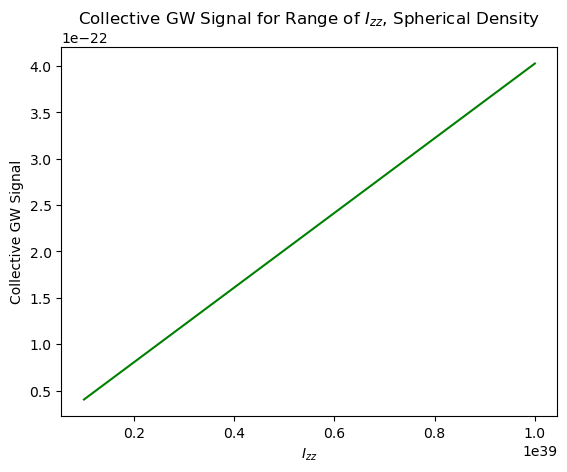

In [21]:
#now to find the collective GW signal
ep_rand_ang = np.random.choice(ep_rand_small, size = dist_ang_size)
freq_sample_ang = np.random.choice(freq_sample_small, size = dist_ang_size)

#first restrict A_GW to the population described by dist_ang
init_A_GW_ang = (16*(math.pi**2)*(6.67e-11)*(10**38)*ep_rand_ang*(freq_sample_ang**2))/(((3e8)**4)*dist_ang*3.086e16)

A_GW_ang = init_A_GW_ang[np.isfinite(init_A_GW_ang)]

collective_GW_sig = dist_ang_size*np.average(A_GW_ang)
print(collective_GW_sig)

#plot how the collective signal changes for a continuous distribution of I_zz
I_zz = np.linspace((10**38), (10**39), num = 10)
collective_A_GW_ang_plot = dist_ang_size*np.average((16*(math.pi**2)*(6.67e-11)*ep_rand_ang*(freq_sample_ang**2))/
                           (((3e8)**4)*dist_ang*3.086e16))*I_zz

plt.plot(I_zz, collective_A_GW_ang_plot, color = "green")
plt.title("Collective GW Signal for Range of $I_{zz}$, Spherical Density")
plt.xlabel("$I_{zz}$")
plt.ylabel("Collective GW Signal")
plt.show()

#write to df
#import pandas as pd
#df_I_zz = pd.DataFrame(I_zz)
#df_coll_GW = pd.DataFrame(collective_A_GW_ang_plot)
#df_total = pd.concat([df_I_zz, df_coll_GW], axis = 1)
#df_total.to_csv("test_GW_line_2", index = False)

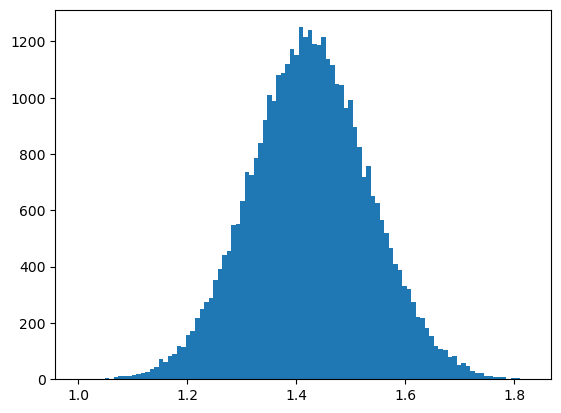

In [23]:
#create the I_zz distribution

#assuming a log normal distribution that follows the grey (all) distribution
#given in Lim et al. Fig. 7

I_zz_dist = np.random.normal(1.425, 0.1100, size = 4000000) #40,000
I_zz_dist_small = np.random.normal(1.425, 0.1100, size = 40000)
plt.hist(I_zz_dist_small, bins = 100)
plt.show()

#this seems to be within the range given by Worley et al. for the
#I_zz vs. freq. distribution for some of the models used

In [24]:
#get sensitivity curves for GW detectors
ET_sensitivity_freq = np.loadtxt("ET-0000A-18_ETDSensitivityCurveTxtFile.txt", usecols = (0))
ET_sensitivity_GW = np.loadtxt("ET-0000A-18_ETDSensitivityCurveTxtFile.txt", usecols = (2))
AligoP_sens_freq = np.loadtxt("AplusDesign.txt", usecols = (0))
AligoP_sense_GW = np.loadtxt("AplusDesign.txt", usecols = (1))
kagra_sen_freq = np.loadtxt("bKAGRA.txt", usecols = (0))
kagra_sen_GW = np.loadtxt("bKAGRA.txt", usecols = (1))
Aligo_sen_freq = np.loadtxt("aLIGO.txt", usecols = (0))
Aligo_sen_GW = np.loadtxt("aLIGO.txt", usecols = (1))
Avirgo_sen_freq = np.loadtxt("AdV.txt", usecols = (0))
Avirgo_sen_GW = np.loadtxt("AdV.txt", usecols = (1))

2.723084790926365


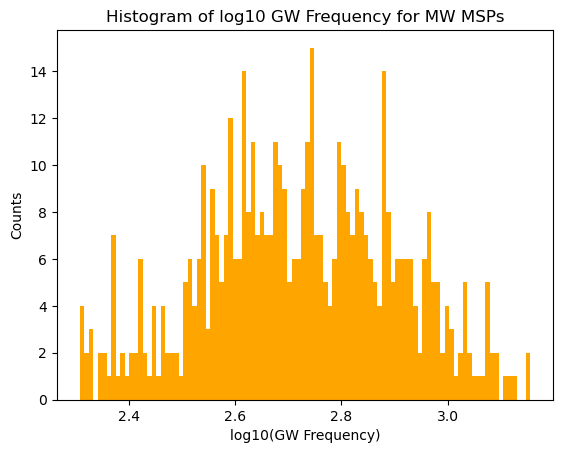

2.723084790926365
0.1825273530723286


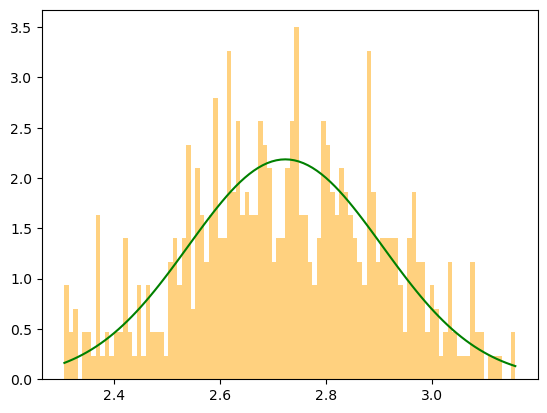

In [25]:
#plot the GW frequency distribution

#from Miller et al.: f_GW = 2f_rot
f_GW = 2*high_freq_array
print(np.average(np.log10(f_GW)))

#plot all distributions
plt.hist(np.log10(f_GW), bins = 100, color = "orange")
plt.title("Histogram of log10 GW Frequency for MW MSPs")
plt.ylabel("Counts")
plt.xlabel("log10(GW Frequency)")
plt.show()

_, bins, _ = plt.hist(np.log10(f_GW), 100, density=1, alpha=0.5, color = "orange")
mu_GW, sigma_GW = scipy.stats.norm.fit(np.log10(f_GW))

#find mu and sigma
print(mu_GW)
print(sigma_GW)

f_GW_best_fit_line = scipy.stats.norm.pdf(bins, mu_GW, sigma_GW)
plt.plot(bins, f_GW_best_fit_line, color = "green")
plt.show()

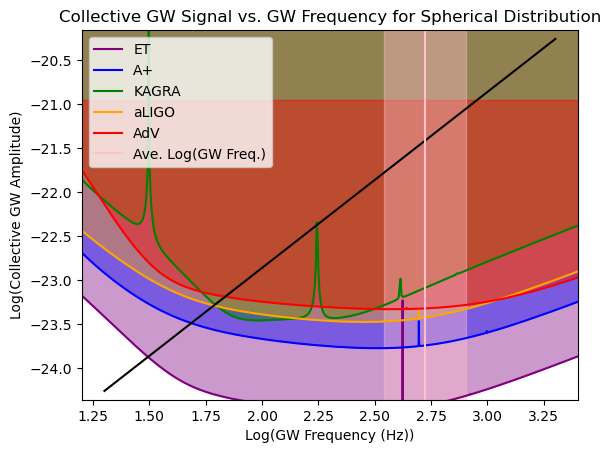

In [26]:
#find the spectrum of the collective GW signal compared to a range of GW frequencies
I_zz_spectrum = np.random.choice(I_zz_dist_small, size = dist_ang_size)
freq_range = np.linspace(10, 1000, 1000)

collective_A_GW_ang_spectrum = dist_ang_size*(np.average((16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum*10e38)*ep_rand_ang)
                                                        /(((3e8)**4)*dist_ang*3.086e16)))*((freq_range**2))

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

#plot the collective signal
plt.plot(np.log10(2*freq_range), np.log10(collective_A_GW_ang_spectrum), color = "black")
plt.title("Collective GW Signal vs. GW Frequency for Spherical Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

plt.xlim(np.log10(2*freq_range).min() - 0.1, np.log10(2*freq_range).max() + 0.1)
plt.ylim(np.log10(collective_A_GW_ang_spectrum).min() - 0.1, np.log10(collective_A_GW_ang_spectrum).max() + 0.1)
plt.legend()
plt.show()

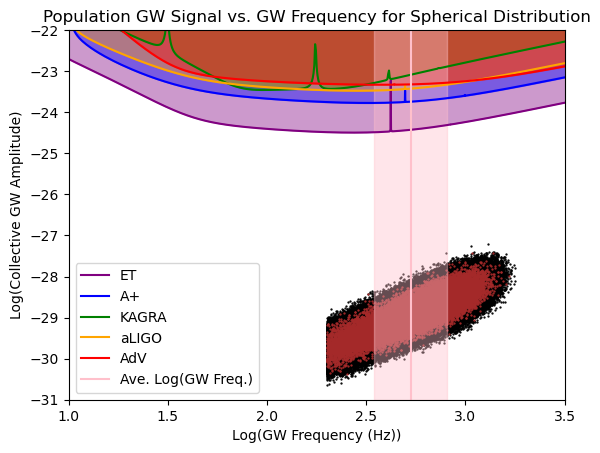

In [27]:
#plot the entire population on the GW freq. vs. GW signal plot
#find the spectrum of the collective GW signal compared to a range of GW frequencies
I_zz_spectrum_1 = np.random.choice(I_zz_dist_small, size = MWB_small_size)
I_zz_spectrum_2 = np.random.choice(I_zz_dist, size = MWB_size)

A_GW_pop_small = (16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum_1*(10**38))*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)
A_GW_pop = (16*(math.pi**2)*(6.67e-11)*(I_zz_spectrum_2*(10**38))*ep_rand*(freq_sample**2))/(((3e8)**4)*dist*3.086e16)

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

#plot the population's signal
plt.scatter(np.log10(2*freq_sample), np.log10(A_GW_pop.astype(float)), color = "black", s = 0.4)
plt.scatter(np.log10(2*freq_sample_small), np.log10(A_GW_pop_small.astype(float)), color = "brown", s = 0.4)
plt.title("Population GW Signal vs. GW Frequency for Spherical Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

plt.xlim(1, 3.5)
plt.ylim(-31, -22)
plt.legend()
plt.show()

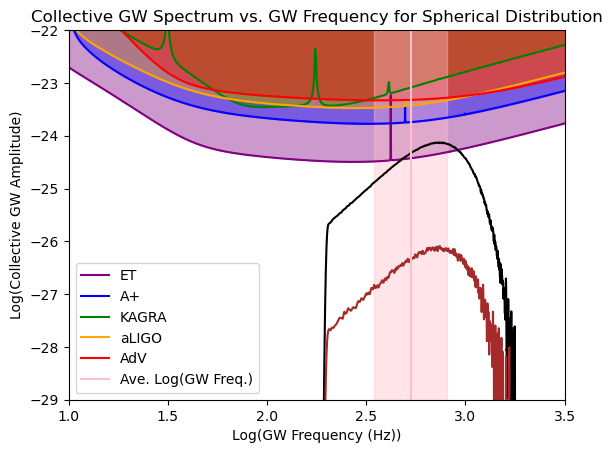

In [30]:
#collective signal take 2: gaussian addition approach

#need to plot each A_GW point as a gaussian instead of a point, then add

#define Gaussian curve
def Gaussian_GW_signal(a, b, c, x):
    return a*np.exp(-((x - b)**2)/(2*(c**2)))

#add Gaussian curves together
def sum_Gaussian_GW_signal(a, b, c, x):
    arr_i = np.zeros(x.size)
    for i in range(a.size):
        arr_i = arr_i + Gaussian_GW_signal(a[i], b[i], c, x)
        
    return arr_i

#find GW signal for a range of I_zz for entire population
I_zz_ind_sample = np.random.choice(I_zz_dist, size = 4000000)*(10**38)
I_zz_ind_sample_small = np.random.choice(I_zz_dist, size = 40000)*(10**38)
A_GW_ind = (16*(math.pi**2)*(6.67e-11)*(I_zz_ind_sample)*ep_rand*(freq_sample**2))/(((3e8)**4)*dist*3.086e16)
A_GW_ind_small = (16*(math.pi**2)*(6.67e-11)*(I_zz_ind_sample_small)*ep_rand_small*(freq_sample_small**2))/(((3e8)**4)*dist_small*3.086e16)

#define parameters: a = A_GW, b = GW freq.
x = np.linspace(freq_sample.min() - 10, freq_sample.max() + 10, 5000) #frequency range to plot over
x_2 = np.linspace(freq_sample_small.min() - 10, freq_sample_small.max() + 10, 5000)
a = A_GW_ind #GW signal for each MSP
a_2 = A_GW_ind_small
b = freq_sample #GQ freq. for each MSP
b_2 = freq_sample_small
c = 1

A_GW_coll_signal = sum_Gaussian_GW_signal(a, b, c, x)
A_GW_coll_signal_small = sum_Gaussian_GW_signal(a_2, b_2, c, x_2)

fig, ax = plt.subplots()
#plot sensitivity curves for ET, aLIGO A+, KAGRA, aLIGO, AdV:
ax.plot(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW), color = "purple", label = "ET")
ax.plot(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW), color = "blue", label = "A+")
ax.plot(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW), color = "green", label = "KAGRA")
ax.plot(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW), color = "orange", label = "aLIGO")
ax.plot(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW), color = "red", label = "AdV")


ax.fill_between(np.log10(ET_sensitivity_freq), np.log10(ET_sensitivity_GW).max(), 
                np.log10(ET_sensitivity_GW), alpha = 0.4, color = "purple")
ax.fill_between(np.log10(AligoP_sens_freq), np.log10(AligoP_sense_GW).max(), 
                np.log10(AligoP_sense_GW), alpha = 0.4, color = "blue")
ax.fill_between(np.log10(kagra_sen_freq), np.log10(kagra_sen_GW).max(), 
                np.log10(kagra_sen_GW), alpha = 0.4, color = "green")
ax.fill_between(np.log10(Aligo_sen_freq), np.log10(Aligo_sen_GW).max(), 
                np.log10(Aligo_sen_GW), alpha = 0.4, color = "orange")
ax.fill_between(np.log10(Avirgo_sen_freq), np.log10(Avirgo_sen_GW).max(), 
                np.log10(Avirgo_sen_GW), alpha = 0.4, color = "red")

plt.plot(np.log10(2*x), np.log10(A_GW_coll_signal), color = "black")
plt.plot(np.log10(2*x_2), np.log10(A_GW_coll_signal_small), color = "brown")
plt.title("Collective GW Spectrum vs. GW Frequency for Spherical Distribution")
plt.xlabel("Log(GW Frequency (Hz))")
plt.ylabel("Log(Collective GW Amplitude)")

#plot the ave. GW freq. for the population of ATNF MSPs and 1 sigma width
plt.axvline(x = mu_GW, color = 'pink', label = 'Ave. Log(GW Freq.)')
ax.axvspan(mu_GW - sigma_GW, mu_GW + sigma_GW, alpha=0.4, color='pink')

#plt.xlim(np.log10(2*freq_spect_sample).min() - 0.1, np.log10(2*freq_spect_sample).max() + 0.1)
#plt.ylim(np.log10(A_GW_ind.astype("float")).min() - 0.1, np.log10(A_GW_ind.astype("float")).max() + 0.1)
plt.xlim(1, 3.5)
plt.ylim(-29, -22)
plt.legend()
plt.show()

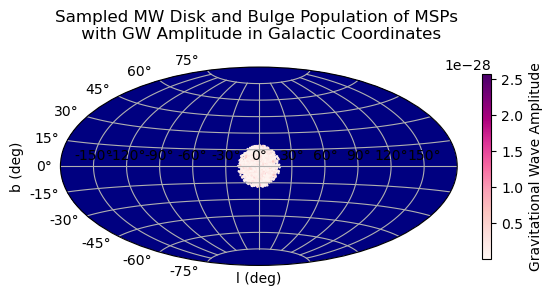

In [31]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW_1, s = 0.5, cmap = 'RdPu')

cb = plt.colorbar(sc, label = "Gravitational Wave Amplitude", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Amplitude in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

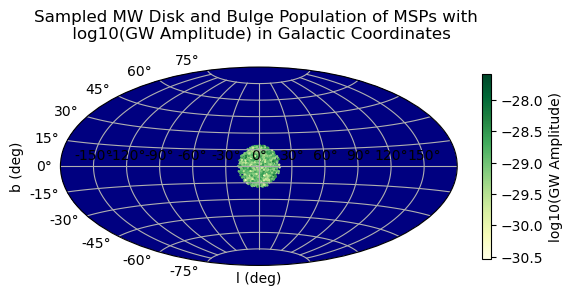

In [32]:
#make a similar 2D plot as the ellipticity one but with the GW amplitude instead (log scale version)
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW_1), s = 0.5, cmap = 'YlGn')

cb = plt.colorbar(sc, label = "log10(GW Amplitude)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with \n log10(GW Amplitude) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

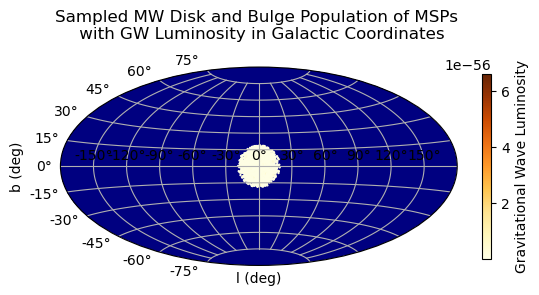

In [33]:
#make a similar 2D plot as the ellipticity one but with the GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = A_GW_1**2, s = 0.5, cmap = 'YlOrBr')

cb = plt.colorbar(sc, label = "Gravitational Wave Luminosity", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

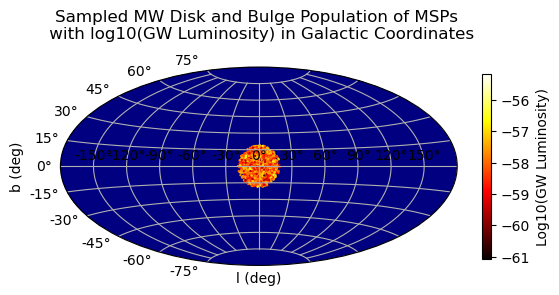

In [34]:
#make a similar 2D plot as the ellipticity one but with the log 10 GW luminosity instead
#try to do a 2D plot of the MW with sampled pulsars
import matplotlib.colors as colors
import matplotlib as mpl

#this is just for the nice blue background :)
q = np.ones([359, 129])
b = np.transpose(q)

fig = plt.figure()

#use aitoff projection to get the oval shape
ax = fig.add_subplot(111, projection='aitoff')
ra = np.linspace(-np.pi, np.pi, 360)
dec = np.linspace(-np.pi/2, np.pi/2, 130)
Ra, Dec = np.meshgrid(ra, dec)

cmap = plt.get_cmap('RdPu')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.jet, norm=colors.LogNorm(vmax=z.max()))
sc = ax.scatter(phi, theta, c = np.log10(A_GW_1**2), s = 0.5, cmap = 'hot')

cb = plt.colorbar(sc, label = "Log10(GW Luminosity)", shrink = 0.5)
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with log10(GW Luminosity) in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

plt.show()

-61.05706222421874


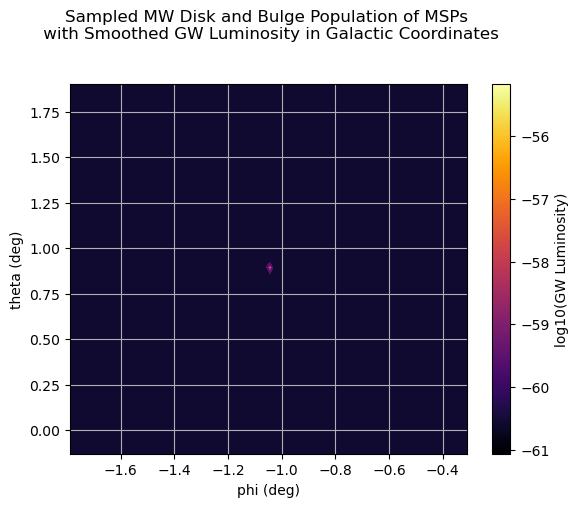

In [35]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the rectangular version, just to check things
from scipy.ndimage import gaussian_filter

print(np.min(np.log10(A_GW_1**2)))

#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data1 = np.histogram2d(phi, theta, bins=130, weights = np.log10(A_GW_1**2))[0]
data2 = gaussian_filter(data1, sigma=0.01667)

plt.contourf(data2.T, cmap='inferno_r', extent = ((180/math.pi)*phi[0], (180/math.pi)*phi[-1], (180/math.pi)*theta[0], (180/math.pi)*theta[-1]))

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), label = "log10(GW Luminosity)")


#plt.colorbar(label = "GW Luminosity")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs \n with Smoothed GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("phi (deg)")
plt.ylabel("theta (deg)")

plt.show()

<Figure size 640x480 with 0 Axes>

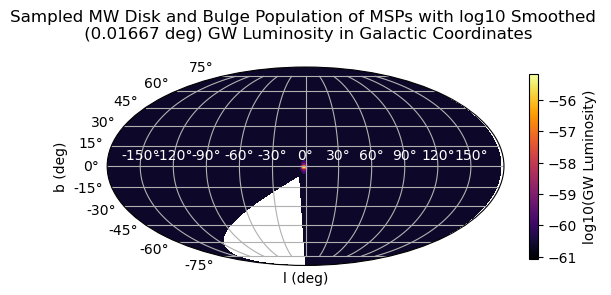

[]


ValueError: zero-size array to reduction operation minimum which has no identity

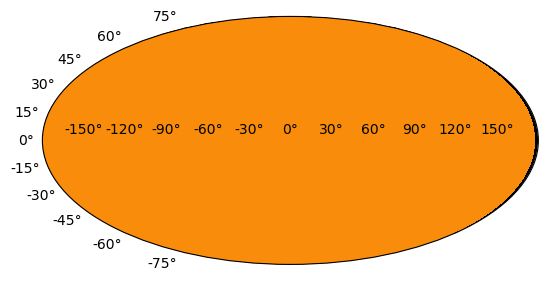

In [36]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
A_GW_cons = A_GW_1[A_GW_1 > 3e-23]
print(A_GW_cons)

data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons**2)))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.01667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'white'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
A_GW_opt = A_GW_1[A_GW_1 > 1e-24]
print(A_GW_opt.size)

data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1 arcminute (width of gaussian is 0.01667 deg/2.91E-4 rad)
data2 = gaussian_filter(data1, sigma=0.01667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.01667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 10 arcminutes 
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (0.1667 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 10 arcminutes
data2 = gaussian_filter(data1, sigma=0.1667) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (0.1667 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 3 deg
data2 = gaussian_filter(data1, sigma=3) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, color = "#3a0000")
#im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.hot, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='hot_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(-61.34052393575108, 
       -54.15859568326009), cmap='hot'), shrink = 0.5,label = "log10(GW Luminosity)")
#cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
#       np.max(np.log10((A_GW_1)**2))), cmap='afmhot'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Spherical Population of MSPs with log10 Smoothed \n (3 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, color = "#3a0000")
#im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(-61.332479414369, 
       -54.30540577610654), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
#cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
#       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (1.7 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_opt)**2))[0]
#assuming that the angular resolution is 1.7 deg
data2 = gaussian_filter(data1, sigma=1.7) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_opt)**2)), 
       np.max(np.log10((A_GW_opt)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (1.7 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#smooth out GW luminosity values with a Gaussian distribution related to angular resolution
#the mollweide projection one!
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

fig = plt.figure()

bin_number = 130
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

#plot with no sensitivity
data1 = np.histogram2d(phi, theta, bins=[lon_edges, lat_edges], weights = np.log10((A_GW_1**2)))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1)**2)), 
       np.max(np.log10((A_GW_1)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Spherical Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#most conservative sensitivity (GEO)
data1 = np.histogram2d(phi[A_GW_1 > 3e-23], theta[A_GW_1 > 3e-23], bins=[lon_edges, lat_edges], weights = np.log10((A_GW_cons)**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_cons)**2)), 
       np.max(np.log10((A_GW_cons)**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 Smoothed \n (10 deg) GW Luminosity in Galactic Coordinates (conservative)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

#second plot with best sensitivity (ET)
data1 = np.histogram2d(phi[A_GW_1 > 1e-24], theta[A_GW_1 > 1e-24], bins=[lon_edges, lat_edges], weights = np.log10((A_GW[A_GW > 1e-24])**2))[0]
#assuming that the angular resolution is 10 deg
data2 = gaussian_filter(data1, sigma=10) 

#use mollweide projection b/c aitoff is messed up (though that might just be the bounds)
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

im = ax.pcolormesh(Ra, Dec, b, cmap=plt.cm.inferno, norm=colors.LogNorm(vmax=z.max()))
cf = ax.contourf(lon_edges[:-1], lat_edges[:-1], data2.T, cmap='inferno_r')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(np.log10((A_GW_1[A_GW_1 > 1e-24])**2)), 
       np.max(np.log10((A_GW_1[A_GW_1 > 1e-24])**2))), cmap='inferno'), shrink = 0.5,label = "log10(GW Luminosity)")
plt.grid()

plt.title("Sampled MW Disk and Bulge Population of MSPs with log10 \n Smoothed (10 deg) GW Luminosity in Galactic Coordinates (best)", y = 1.1)
plt.xlabel("l (deg)")
plt.ylabel("b (deg)")

#mpl.rcParams['axes.labelcolor'] = 'black'
plt.xticks(color = "white")

plt.show()

In [ ]:
#look at GW detector constraints on signal and number of MSPs
A_GW_cons = A_GW_1[A_GW_1 > 3e-23]
print("A_GW_cons size = ")
print(A_GW_cons.size)
print("Cons. ave. GW freq. = ")
freq_sample2 = freq_sample[np.isfinite(init_A_GW)]
print(np.average(freq_sample2[A_GW > 3e-23]))
print("Cons. ave. GW lum. =")
print(np.average((A_GW_cons**2)))

A_GW_opt = A_GW_1[A_GW_1 > 1e-24]
print("A_GW_opt size = ")
print(A_GW_opt.size)
print("Opt. ave. GW freq. = ")
print(np.average(freq_sample2[A_GW > 1e-24]))
print("Opt. ave. GW lum. =")
print(np.average((A_GW_opt**2)))